In [1]:
# Python 3 Theano/Lasagne version of Yahoo's Open NSFW https://github.com/yahoo/open_nsfw
# this module depends on google.protobuf, PIL, lasagne, theano

# the nsfw.pkl is coverted using pycaffe (in python2)
# nsfw_model/deploy.prototxt is from Open NSFW

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

from lasagne.layers import Conv2DLayer, ElemwiseSumLayer, InputLayer, Pool2DLayer
from lasagne.layers import DenseLayer, NonlinearityLayer, BatchNormLayer
from lasagne.nonlinearities import softmax, rectify

Using gpu device 0: GeForce GTX 965M (CNMeM is disabled, cuDNN 4007)


In [3]:
# cafe_pb2 is copy from pycaffe
import caffe_pb2
from google.protobuf import text_format
import pickle

# build_nsfw_net by parsing 
def build_nsfw_net(input_var, 
                   nsfw_pkl_path="nsfw.pkl", 
                   deploy_prototxt_path="nsfw_model/deploy.prototxt"):
    """
    Construct the open NSFW network by parsing nsfw_model/deploy.prototxt.
    Initialize the weight using nsfw.pkl.
    """
    with open(deploy_prototxt_path, 'r') as f:    
        m=text_format.Merge(f.read(), caffe_pb2.NetParameter())
    
    with open(nsfw_pkl_path, "rb") as f:
        trained_layers = pickle.load(f, encoding="latin1")
    
    i = 0
    net = {}
    var = {}
    pretrained_dict = dict(trained_layers)
    nonlinearity_dict = {
        "ReLU": rectify,
        "Softmax": softmax
    }
    layer_class_dict = {
        "Input": InputLayer,
        "Convolution": Conv2DLayer,
        "BatchNorm": BatchNormLayer,
        "Pooling": Pool2DLayer,
        "Eltwise": ElemwiseSumLayer,
        "InnerProduct": DenseLayer,
    }
    for x in nonlinearity_dict:
        layer_class_dict[x] = lasagne.layers.NonlinearityLayer

    while i < len(m.layer):
        x = m.layer[i]
        top = x.top[0]
        i+=1
        kwargs = {}
        layer_class = layer_class_dict[x.type]
        if len(x.bottom) == 1:
            kwargs['incoming'] = var[x.bottom[0]]
        elif len(x.bottom) > 1:
            kwargs['incomings'] = [var[b] for b in x.bottom]

        if x.type == "Input":
            params = x.input_param
            kwargs['input_var'] = input_var
            kwargs['shape'] = tuple(params.shape[0].dim)
        elif x.type == 'Convolution':
            kwargs['W'] = pretrained_dict[x.name][0]
            kwargs['b'] = pretrained_dict[x.name][1]
            kwargs['flip_filters'] = False
            params = x.convolution_param
            kwargs['num_filters'] = params.num_output
            kwargs['filter_size'] = params.kernel_size[0]
            if params.stride:
                kwargs['stride'] = params.stride[0]
            if params.pad:
                kwargs['pad'] = params.pad[0]
            kwargs['nonlinearity'] = lasagne.nonlinearities.linear 
        elif x.type == "BatchNorm":
            batch_stats = pretrained_dict[x.name]
            kwargs['mean'] = batch_stats[0]/batch_stats[2]
            kwargs['inv_std'] = 1/np.sqrt(batch_stats[1]/batch_stats[2])
            kwargs['epsilon'] = 1e-5
            if i < len(m.layer) and m.layer[i].type == "Scale":
                y = m.layer[i]
                i+=1
                assert top == y.bottom[0]
                top = y.top[0]
                kwargs['gamma'] = pretrained_dict[y.name][0]
                kwargs['beta'] = pretrained_dict[y.name][1]
            else:
                assert print("batchnorm without scale")
        elif x.type == "Pooling":
            params = x.pooling_param
            kwargs['mode'] =  ['max', 'average_exc_pad'][params.pool]
            kwargs['pool_size'] = params.kernel_size
            if params.stride:
                kwargs['stride'] = params.stride
            if params.pad:
                kwargs['pad'] = params.pad
            if not params.pad:
                kwargs['ignore_border'] = False
        elif x.type == 'Eltwise':
            pass
        elif x.type == "InnerProduct":
            params = x.inner_product_param
            kwargs['num_units'] = params.num_output
            kwargs['W'] = pretrained_dict[x.name][0].T
            kwargs['b'] = pretrained_dict[x.name][1]
            kwargs['nonlinearity'] = lasagne.nonlinearities.linear
        elif x.type in nonlinearity_dict:
            kwargs['nonlinearity'] = nonlinearity_dict[x.type]
        else:
            assert print("??", x.name, x.type)

        net[x.name] = var[top] = layer_class(**kwargs)
    return net[x.name], net

In [4]:
nsfw_input_var = T.tensor4()
nsfw_model, nsfw_net = build_nsfw_net(nsfw_input_var)

In [5]:
# NSFW without the approx jpg processing
nsfw_output = lasagne.layers.get_output (nsfw_model, deterministic=True)
nsfw_score_fn = theano.function([nsfw_input_var], nsfw_output[0][1])

In [6]:
# Followings are helper functions, used for preprocessing and format transforming.
# The preprocessing steps of  Open NSFW are:
# * resize the image to 256x256 RGB
# * JPEG compressed and then decompressed (with PIL's default setting)
# * rearange the axis and reshape the image data to 1xCxHxW
# * substract color means [104, 117, 123]
# * center crop the image to 224x224

In [75]:
from PIL import Image
from io import StringIO, BytesIO

# open_nsfw has a resize_image function
# what id does is resizing and JPEG comressing, decompressing.
# We add the prefix __ to avoid confusion
def __resize_image(img_fn, sz=(256, 256), convert_to_array=True):
    if isinstance(img_fn, str):
        im = Image.open(img_fn)
    else:
        assert isinstance(img_fn, Image.Image)
        im = img_fn
    if im.mode != "RGB":
        im = im.convert('RGB')
    imr = im.resize(sz, resample=Image.BILINEAR)
    if convert_to_array:
        return np.asarray(imr)
    else:
        return imr

In [8]:
# Color means
cmean = np.array([104, 117, 123], dtype=theano.config.floatX).reshape(3,1,1)

In [9]:
# convert image to Theano/Lasagne input format 
def process(img):
    assert len(img.shape) == 3
    w, h = img.shape[:2]
    img = img.swapaxes(1,2).swapaxes(0,1)
    img = img[::-1, :, :].astype(cmean.dtype) - cmean
    return img.reshape(1,3,w,h)

# crop the image like Open NSFW
def crop(img):
    assert len(img.shape) == 4
    return img[:, :, 16:16+224, 16:16+224]

In [10]:
# convert Theano/Lasagne input format back to an image
def deprocess(img):
    assert len(img.shape)==4 and img.shape[0]==1
    img = (img[0] + cmean).clip(0, 255).astype('uint8')
    return img[::-1].swapaxes(0,1).swapaxes(1,2)

In [11]:
# deproccess the input, jpeg compressed and then decompressed, and finally process 
def make_jpg(img_array):
    if isinstance(img_array, Image.Image):
        img = img_array
    else:
        assert len(img_array.shape) == 4
        img = Image.fromarray(deprocess(img_array))
    fh_im = BytesIO()
    img.save(fh_im, format='JPEG')
    fh_im.seek(0)
    return process(np.asarray(Image.open(fh_im)))

In [76]:
def nsfw_score(img):
    """
    Compute NSFW score for img. 
    img can be either a filename, a PIL Image
    """
    img_input = make_jpg(__resize_image(img, convert_to_array=False))
    return float(nsfw_score_fn(crop(img_input)))

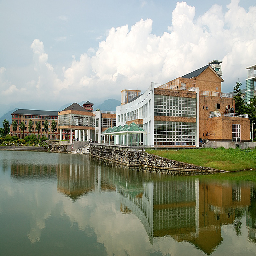

NSFW score of img/ndhu.jpg is 0.00014


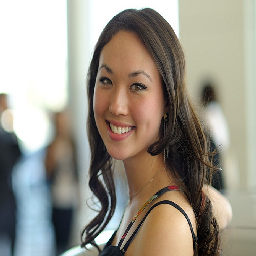

NSFW score of img/smile_face.jpg is 0.03488


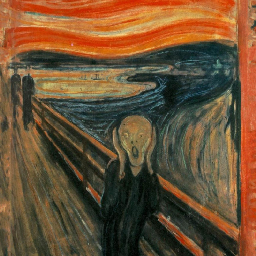

NSFW score of img/the_scream.jpg is 0.00248


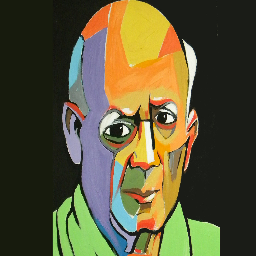

NSFW score of img/Pablo_Picasso1.jpg is 0.06459


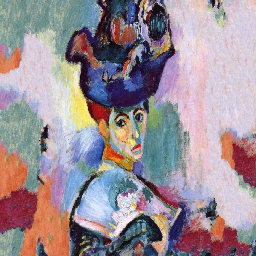

NSFW score of img/woman-with-hat-matisse.jpg is 0.01086


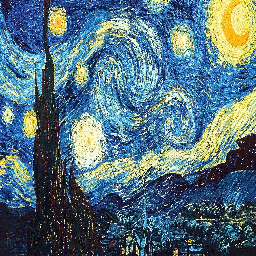

NSFW score of img/starry_night.jpg is 0.00174


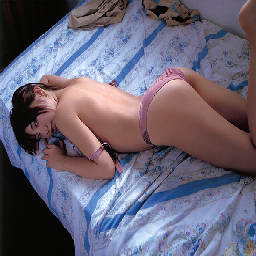

NSFW score of <http.client.HTTPResponse object at 0x7fe288037358> is 0.95220


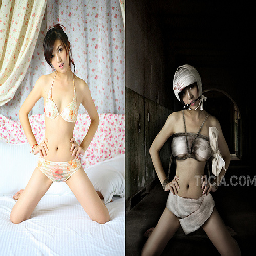

NSFW score of <http.client.HTTPResponse object at 0x7fe288049f28> is 0.98449


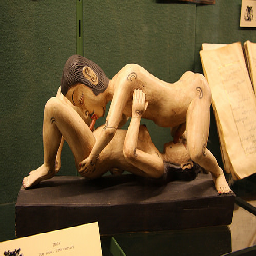

NSFW score of <http.client.HTTPResponse object at 0x7fe288049c50> is 0.99179


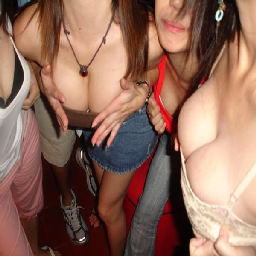

NSFW score of <http.client.HTTPResponse object at 0x7fe288049d30> is 0.95228


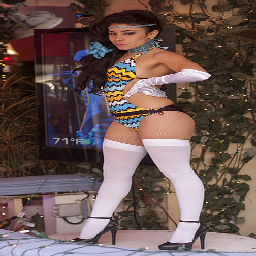

NSFW score of <http.client.HTTPResponse object at 0x7fe288049f28> is 0.50768


In [80]:
if __name__ == "__main__":
    import glob
    from itertools import chain
    from urllib.request import urlopen
    try:
        from IPython.display import display
    except:
        print("IPython.display is not installed")
        display = lambda x:False
    # CC-BY images from the flickr
    cc_by_urls = ["https://farm1.staticflickr.com/53/132063430_ec0e7c5988_z_d.jpg", # >0.95
                 "https://farm3.staticflickr.com/2535/3894751161_51c9b060de_z_d.jpg", # >0.95
                 "https://farm8.staticflickr.com/7342/27120530295_21e87ed3be_z_d.jpg", # >0.95
                 "https://farm1.staticflickr.com/40/92101780_62da7c8d3a_o_d.jpg", # >0.95
                 "https://farm8.staticflickr.com/7377/16466652791_bab067aa26_z_d.jpg", # ~0.5
                 ]
    # all image in img/ has a NSFW score near 0, except woman-with-hat-matisse scores ~0.1 
    for img_fn in chain(glob.glob("img/*"), map(urlopen, cc_by_urls)):
        img = Image.open(img_fn)
        display(img.resize((256,256)))
        print("NSFW score of {} is {:.5f}".format(img_fn, nsfw_score(img)))
